# Simulate IBD sharing under time transect with PEDSIM

In [61]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import socket
import os as os
import sys as sys
import multiprocessing as mp

import msprime
import tskit

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name.startswith("bionc") or socket_name.startswith("hpc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer"
elif socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald laptop detected.")
    path = "/home/hringbauer/git/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

sys.path.append("./package/") # Append Hapsburg Folder
from hapsburg.PackagesSupport.pp_individual_roh_csvs import combine_ROH_df

sys.path.insert(0, "/mnt/archgen/users/hringbauer/git/auto_popgen/python3/")
from ibd_sites_stats import * # Import all functions

print(f"CPU Count: {mp.cpu_count()}")

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

hpc030
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer
CPU Count: 128


In [148]:
### Post process a single tree for two inds

def get_roh_from_tree(tree_sequence, inds=[0,1], max_t=100):
    """Extract vector of all ROH from tree sequence.
    inds: Pair of individuals to analyze [list]
    max_t: Maximum time until which to call ROH"""
    
    roh_vec = []
    t_vec = []

    for tree in tree_sequence.trees():
        try:
            t_mrca = tree.tmrca(inds[0], inds[1])
        except ValueError: # If no TMRCA found (nodes stop)
            t_mrca = np.inf 
            
        if t_mrca < max_t:
            l = tree.interval
            roh_vec.append(l)
            t_vec.append(t_mrca)
    return roh_vec, t_vec

def merge_called_blocks(roh_vec, max_gap=0, 
                        output=False):
        """Merge Blocks in ROH vector (list of start/end position in Morgan)
        Gap is given in Morgan"""
        if len(roh_vec) == 0:
            return roh_vec  # In case of empty dataframe don't do anything

        out_vec = []
        start_c, end_c = roh_vec[0]
        
        for roh in roh_vec[1:]:
            ### Calculate Conditions
            short_g = roh[0] - end_c
            assert(short_g>=0) # Sanity Check
            
            if short_g<max_gap:
                end_c = roh[1]

            else:  # Save and save next ROH
                out_vec.append([start_c, end_c])
                start_c, end_c = roh
                
        out_vec.append([start_c, end_c]) # Append the last block

        if output:
            print(f"Merged n={len(roh_vec) - len(out_vec)} gaps < {max_gap} M")
        return out_vec
    
def extract_roh_lengths(l_vec, min_l=0.04, max_l=0.2, output=False):
    """Extract all ROH with length in length bin"""
    lengths = np.array([l[1]-l[0] for l in l_vec])
    lengths = lengths[(lengths>min_l) & (lengths<max_l)]
    if output:
        print(f"Extracted {len(lengths)}/{len(l_vec)} ROH {min_l}-{max_l}")
    return lengths


def create_df(roh_vec=[], ch=0, ind=""):
    """Create hapsburg ROH dataframe from roh_vec.
    Return df
    roh_vec: nx2 list of ROH.
    """
    if len(roh_vec)==0:
        df = pd.DataFrame(columns = ["StartM", "EndM", "lengthM", 
                                     "Start", "End", "length", "ch", "ind"])
        return df
    
    roh_vec = np.array(roh_vec) # For indexing
    df = pd.DataFrame({"StartM": roh_vec[:, 0],
                       "EndM": roh_vec[:, 1]})
    df["lengthM"] = df["EndM"] - df["StartM"]
    
    ### Fill in positional values (default 1e6 bp/M)
    df["Start"] = df["StartM"] * 1e6
    df["End"] = df["EndM"] * 1e6
    df["length"] = df["End"] - df["Start"]
    
    ### Other Fields
    df["ch"] = ch
    df["ind"] = ind
    return df
    

def simulate_roh_chromosomes(ch_ls, Ne=100, sample_size=2, pairs=[(0,1),],
                             max_t=100, end_time=None, merge_gap=-0.1, delta_t=0,
                             record_full_arg=False, output=False, savepath=""):
    """Simulate and post-process ROH for chromosomes
    ch_ls: List of Lengths of Chromosomes to simulate [in Morgan]
    Ne: Diploid population size to simulate
    sample_size: How many samples to simulate.
    max_t: How many generations back.
    Gap to merge
    
    Return dataframe of ROH blocks"""
    
    ind = []
    roh_start, roh_end = [], []
    chs = []
    
    df_res = []

    assert(len(ch_ls)>0) # Sanity Check that not empty
    for i, ch_l in enumerate(ch_ls):
        ### Legacy version
        #tree_sequence = msprime.simulate(sample_size=sample_size, Ne=Ne,
        #                                 record_full_arg=record_full_arg,
        #                                 end_time=end_time,
        #                                 length=ch_l, recombination_rate=1)
        ### Newer version
        #### The Demographic Model
        dgy = msprime.Demography()
        dgy.add_population(name="A", initial_size=Ne)
        
        #### Samples (taken at different times)
        samples = [
            msprime.SampleSet(1, population="A", time=0, ploidy=1),   # 1 haploid genomes sampled at t=0
            msprime.SampleSet(1, population="A", time=delta_t, ploidy=1),  # 1 haploid genome sampled 10 generations ago
        ]

        #### Recombination Rate
        morgan_positions = [0.0, ch_l]  # in Morgans
        recombination_rates = [1.0]    # 1 Morgan per Morgan = uniform recombination
        
        rate_map = msprime.RateMap(
            position=morgan_positions,
            rate=recombination_rates,
        )

        #rate_map.units = "morgan"
        
        # Simulate the ancestry
        tree_sequence = msprime.sim_ancestry(samples=samples, demography=dgy, sequence_length=ch_l, 
                                             recombination_rate=rate_map, discrete_genome=False,
                                             end_time=end_time) #discrete_genome=False, 
            
        ### Extract ROH/IBD vector
        for p in pairs:
            roh_vec, t_vec = get_roh_from_tree(tree_sequence, inds=p, max_t=max_t)
            
            if merge_gap>0:
                roh_vec = merge_called_blocks(roh_vec=roh_vec, 
                                              max_gap=merge_gap, output=output)
            
            ind = "ind_" + str(p[0]) + "_" +  str(p[1]) # Create Individual label
            df_t = create_df(roh_vec, ch=i, ind=ind)
            df_res.append(df_t)
            
    df = pd.concat(df_res).reset_index(drop=True) # Make one big summary Dataframe      
    return df

############################################################
### Simulate multiple replicates of independent Inds

def sim_ind_full_inds(lgths=[], inds=10, replicates=10, min_cm=0.04,
                      ne=500, sample_size=2, merge_gap=1e-4, delta_t=0,
                      max_t=100, end_time=None,
                      record_full_arg=False,
                      savefolder="./Simulated/msprime/fixed_Ne/"):
    """Simulate indeped"""
    if not os.path.exists(savefolder):
        print(f"Creating folder: {savefolder}")
        os.makedirs(savefolder)
    
    for j in range(replicates):
        print(f"Running replicate {j}...")
        df_res_vec =[]

        for r in range(inds):
            df_res = simulate_roh_chromosomes(ch_ls=lgths, Ne=ne, sample_size=sample_size,
                                              max_t=max_t, end_time=end_time, delta_t=delta_t,
                                              merge_gap=merge_gap, output=False,
                                              record_full_arg=record_full_arg,
                                              pairs=[(0,1),], savepath="")

            df_res = df_res[df_res["lengthM"]>min_cm]
            df_res["replicate"] = r
            df_res_vec.append(df_res)

        df_all = pd.concat(df_res_vec)
        savepath = savefolder + str(ne) + "_" + str(j) + ".tsv"
        df_all.to_csv(savepath, sep="\t", index=False)
        print(f"#ROH={len(df_all)}, Successfully saved to {savepath}")
        
        
def produce_ind_roh_dfs(loadfolder = "./Simulated/msprime/fixed_Ne_gaps_merged/",
                        nes = [250, 500, 1000, 2000], reps = 10, inds = 10):
    """Return list of individual ROH dfs. Splits up replicate individuals and
    assigns individuals iids
    nes: Diploid population size estimates
    reps: How many replicates.
    inds: How many individuals"""
    df_rohs = []
    iids, pops = [], []
    
    for ne_dip in nes:
        iid = 0    
        for r in range(reps):
            loadpath = loadfolder + str(ne_dip) + "_" + str(r) + ".tsv" 
            df_load = pd.read_csv(loadpath, sep="\t")
            for ind in range(inds):
                df_t = df_load[df_load["replicate"]==ind]
                df_rohs.append(df_t)
                iids.append(f"rep_{iid}")
                iid+=1
                pops.append("2Ne_" + str(ne_dip*2))
    return df_rohs, iids, pops

# A) Simulate Full ARG
Every recomb. matters

## A1) Same-time scenario
For testing against formulats

## 1a) Simulate constant Ne=500 IBD/ROH (per haplo pair)

In [149]:
### Human Chromosome
ch_len_dict = {1:286.279, 2:268.840, 3:223.361, 4:214.688, 5:204.089, 6:192.040, 7:187.221, 8:168.003, 9:166.359, \
        10:181.144, 11:158.219, 12:174.679, 13:125.706, 14:120.203, 15:141.860, 16:134.038, 17:128.491, 18:117.709, \
        19:107.734, 20:108.267, 21:62.786, 22:74.110}
lgths = np.array(list(ch_len_dict.values()))/100

In [ ]:
%%time
###  Load Chromosome Lengths
#df_lengths = pd.read_csv("./Data/MapLengths/chs_lgths_1240k.tsv", sep="\t")
#lgths = df_lengths["lengthM"]

#lgths = [1.5] # Single Values
sim_ind_full_inds(lgths=lgths, inds=50, replicates=10, min_cm=0.04,
                  ne=500, sample_size=2, merge_gap=-0.1, delta_t=0,
                  max_t=100, end_time=101, 
                  record_full_arg=True,
                  savefolder="./git/hapBLOCK/output/deltaTsim/ne500_00/") 

### Process that IBD sharing

In [158]:
def produce_ind_ibd_dfs_reps(loadfolder = "./git/hapBLOCK/output/deltaTsim/ne500_00/", 
                             nes = [500], reps = 10, inds = 50):
    """Load Individual IBD dataframes across replicates and post-process them.
    Return master dataframe of all IBD segments."""

    df_ibds, iids, pops = produce_ind_roh_dfs(loadfolder = loadfolder,
                        nes = nes, reps = reps, inds = inds)

    df_ibd = pd.concat(df_ibds)
    print(f"Found {len(df_ibd)} IBD segments in {len(iids)} haplotype pairs")
    
    df_ibd["ind"] = "rep_" + df_ibd["replicate"].astype("str")
    df_ibd["iid1"] = df_ibd["ind"]
    df_ibd["iid2"] = df_ibd["ind"]
    return df_ibd

In [155]:
%%time
df_ibds, iids, pops = produce_ind_roh_dfs(loadfolder = "./git/hapBLOCK/output/deltaTsim/ne500_00/",
                        nes = [500], reps = 10, inds = 50)

df_ibd = pd.concat(df_ibds)
print(f"Found {len(df_ibd)} IBD segments in {len(iids)} haplotype pairs")

df_ibd["ind"] = "rep_" + df_ibd["replicate"].astype("str")
df_ibd["iid1"] = df_ibd["ind"]
df_ibd["iid2"] = df_ibd["ind"]

Found 5423 IBD segments in 500 haplotype pairs
CPU times: user 313 ms, sys: 11 ms, total: 324 ms
Wall time: 348 ms


## Plot Haplotype Sharing Histogram

### Plot haplotype sharing Ne=500 - sampled contemporaneously
`npairs_force` is 125 because diploids (500 haploid pairs were simulated)

Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


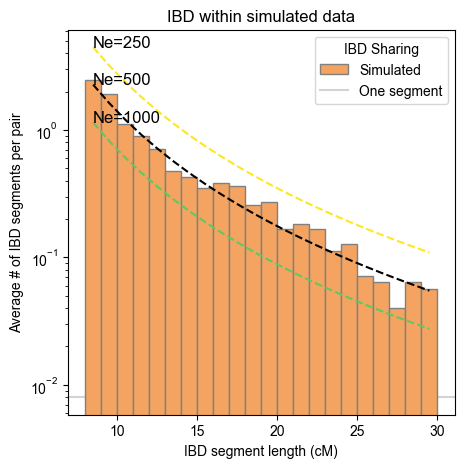

In [156]:
plot_ibd_single_site(df_ibd, df_ibd_ind=[], df_meta=[],
    site="Simulated", iids=iids, title="IBD within simulated data",
    figsize = (5,5), bins = np.arange(8, 31, 1), ax=0, npairs_force=125,
    Ne_plot = [250, 500, 1000], # Diploid Pop Size
    c_plot = ["#fde725", "black", "#5ec962", "#3b528b", "#440154"], alpha=1.0,  # "#21918c",
    legend = True, yscale="log", savepath="", show=True) # ./output/share/gomolova_withinIBD.pdf

## A2) Simulate Range of Delta T time sampling
Simulate delta_ts 0,10,20,30,40,50
10 replicates each with 100 haplotype pairs

In [ ]:
%%time
###  Load Chromosome Lengths
#delta_ts = [0, 10, 20, 30, 40, 50] # Three Time Points
delta_ts = []

for dt in delta_ts:
    sim_ind_full_inds(lgths=lgths, inds=100, replicates=10, min_cm=0.04,
                      ne=500, sample_size=2, merge_gap=-0.1, delta_t=dt,
                      max_t=100, end_time=101, 
                      record_full_arg=True,
                      savefolder=f"./git/hapBLOCK/output/deltaTsim/ne500_00_d{dt}/")

## Plot  Simulation Results

Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


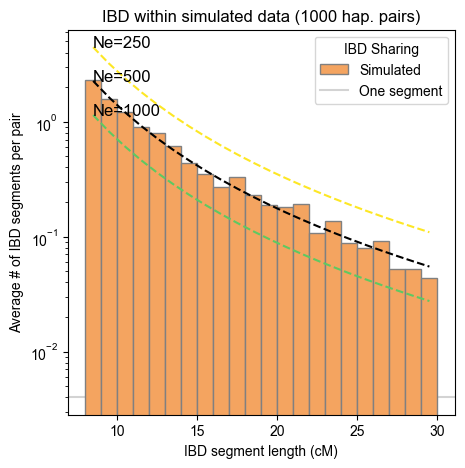

In [161]:
df_ibd = produce_ind_ibd_dfs_reps(loadfolder = "./git/hapBLOCK/output/deltaTsim/ne500_00_d0/", 
                                     nes = [500], reps = 10, inds = 100)
plot_ibd_single_site(df_ibd, df_ibd_ind=[], df_meta=[],
    site="Simulated", iids=iids, title="IBD within simulated data (1000 hap. pairs)",
    figsize = (5,5), bins = np.arange(8, 31, 1), ax=0, npairs_force=250,
    Ne_plot = [250, 500, 1000], # Diploid Pop Size
    c_plot = ["#fde725", "black", "#5ec962", "#3b528b", "#440154"], alpha=1.0,  # "#21918c",
    legend = True, yscale="log", savepath="", show=True) # ./output/share/gomolova_withinIBD.pdf

Found 10963 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


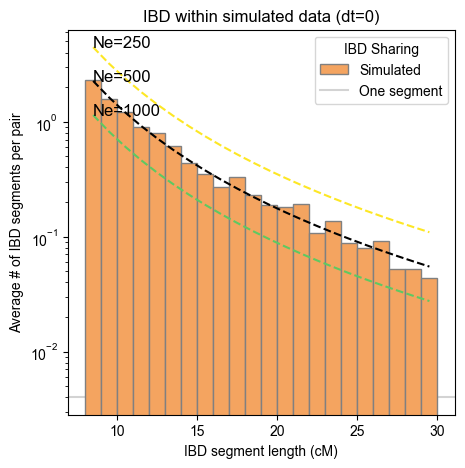

Found 10257 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


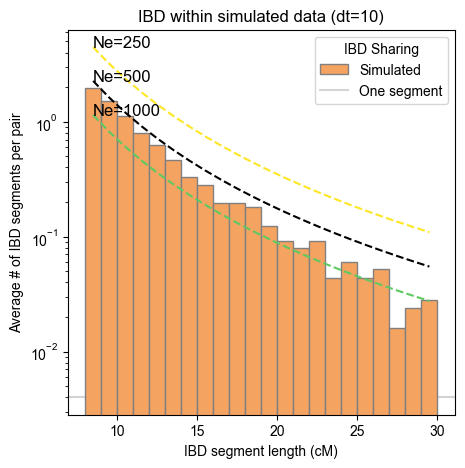

Found 8890 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


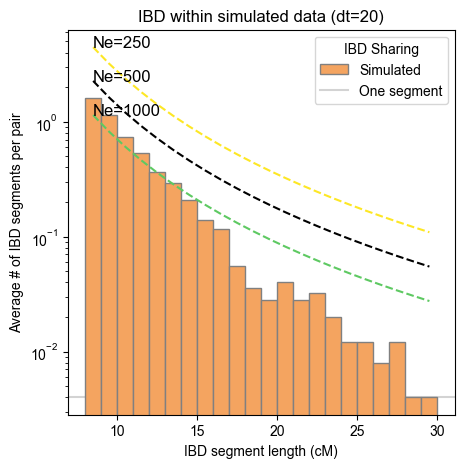

Found 7333 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


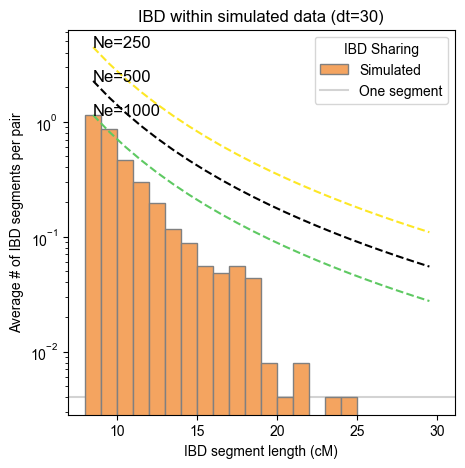

Found 5852 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


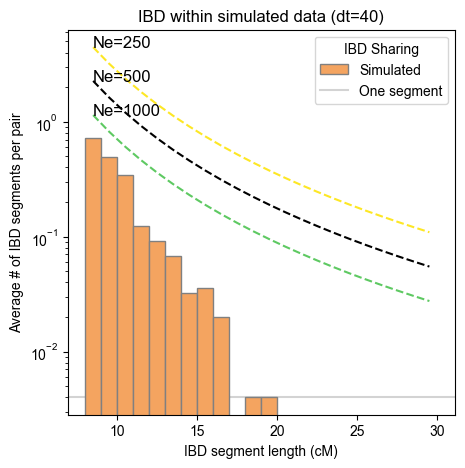

Found 4536 IBD segments in 1000 haplotype pairs
Number of sample 1: 500
Filtered to 124750/124750 non-related iids (sum_IBD>12<100)


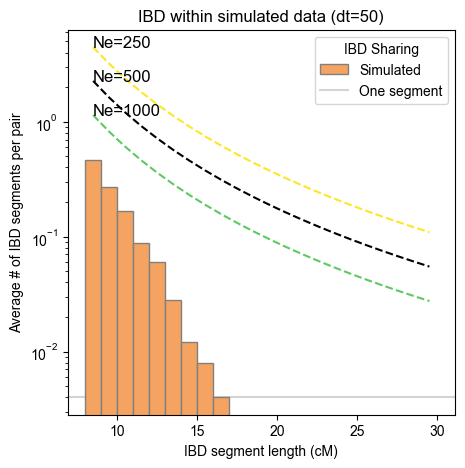

In [169]:
for dt in [0,10,20,30,40,50]:
    df_ibd = produce_ind_ibd_dfs_reps(loadfolder = f"./git/hapBLOCK/output/deltaTsim/ne500_00_d{dt}/", 
                                         nes = [500], reps = 10, inds = 100)
    
    plot_ibd_single_site(df_ibd, df_ibd_ind=[], df_meta=[],
        site="Simulated", iids=iids, title=f"IBD within simulated data (dt={dt})",
        figsize = (5,5), bins = np.arange(8, 31, 1), ax=0, npairs_force=250,
        Ne_plot = [250, 500, 1000], # Diploid Pop Size
        c_plot = ["#fde725", "black", "#5ec962", "#3b528b", "#440154"], alpha=1.0,  # "#21918c",
        legend = True, yscale="log", savepath="", show=True) # ./output/share/gomolova_withinIBD.pdf

# Area 51
Trouble-shoot

In [ ]:
print('test')

In [ ]:
asdf